# Playground

## Import packages

In [40]:
%reload_ext autoreload
%reload_ext tensorboard

# simulation 
import simulator as sim

# data manipulation
import numpy as np
import pandas as pd

# data visualization
%matplotlib inline
import matplotlib.pyplot as plt

# isolation forest
from sklearn.ensemble import IsolationForest

# gan
import gan as g
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, TimeDistributed, LSTM, Input
from tensorflow.keras.optimizers import Adam
from scipy.optimize import least_squares



from datetime import datetime

# evaluation 
from sklearn.metrics import confusion_matrix, precision_score, recall_score

## Sensor and anomaly simulation

### Define values

In [273]:
features = 1  # nbr of time series
series_length = 200  # nbr of simulations
lag = 3  # lag for the ar-series
anomaly_amp = 5
anomaly_freq = 0.01
season_amp = 1  # amplitude of seasonal component
season_period = 50  # season period
e = 0.1

### Set AR-matrices

In [160]:
ar = np.zeros((features, features))
constant = np.zeros(features)
trend = np.zeros(features)

In [161]:
# first time series
ar[0, 0] = 0

constant[0] = 0
trend[0] = 0

In [162]:
# second time series
ar[0, 1] = 0
ar[1, 0] = 0.5
ar[1, 1] = 0

constant[1] = 2
trend[1] = 0

IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
# third time series
ar[1, 2] = 0
ar[2, 0] = 0
ar[2, 1] = 0.3
ar[2, 2] = 0

constant[2] = 10
trend[2] = 0

### Simulate sensor data

In [ ]:
#sensor_df = pd.DataFrame(sensor, index=time)
#anomaly_df = pd.DataFrame(index=time)
#anomaly_df['Point anomaly'] = pd.Series(
#    sim.point_anomaly(anomaly_freq, features, anomaly_amp))
#anomaly_df['Trend anomaly'] = pd.Series(trend_anomaly(0.01, n_sim, 20, 3))

#sensor_df[0] = sensor_df[0] + anomaly_df[
#    'Point anomaly']  # add point anomalies to first time series
#sensor_df.fillna('0')

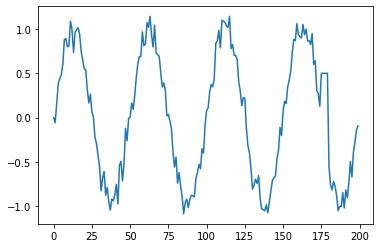

In [304]:
sensor = sim.sensor_simulation(series_length, features, ar, lag, constant, trend, e,
                               season_amp, season_period)
sensor[175:180] = 0.5
time = np.linspace(0, series_length - 1, series_length)
plt.plot(sensor);

#### Alternative simulation

In [ ]:
#empty = np.zeros((150,2))
#model = VARMAX(empty, order=(1, 0), trend='c')

# [trend, trend, ar11, ar12, ar22, ar21, sigma]
#simulations = model.simulate([1, A[0,0], 0, 0, 0.5, 0, 0.1], 150)

#empty = np.zeros(150)
#model = SARIMAX(empty, order=(1, 0, 0), trend='c')
#simulations = model.simulate([1, 0.9, 0.1], 150)
#plt.plot(simulations)

## Models

### Isolation Forest

In [ ]:
model = IsolationForest(n_estimators=100,
                        contamination=0.01,
                        max_samples='auto',
                        behaviour='new')
model.fit(sensor_df)
anomaly_df['Predicted anomaly'] = pd.Series(model.predict(sensor_df))
fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(sensor_df[0], color='red')

a = anomaly_df.loc[anomaly_df['Predicted anomaly'] == -1,
                   ['Point anomaly']]  #anomaly
ax.scatter(a.index, a['Point anomaly'], color='blue');

### GAN

#### Definitions

In [402]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        out_end_ix = end_ix + 1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
 

#### Generate series and split into sequences

In [405]:
timesteps = 30
cut = 160
train = sensor[:cut]
test = sensor [cut:]
train_length = len(train)
test_length = len(test)
train_samples = train_length - timesteps
test_samples = test_length - timesteps

In [406]:
X_tr, y_tr = split_sequences(train, timesteps)
X_te, y_te = split_sequences(test, timesteps)

#### Create GAN

In [407]:
# Creating GAN
units = 50

gen = g.create_generator(timesteps, features, units)
disc = g.create_discriminator(timesteps, features, units)
gan = g.create_gan(disc, gen, timesteps, features)

#### Train GAN

In [408]:
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/train_on_batch/' + current_time + 'train'
train_writer = tf.summary.create_file_writer(train_log_dir)
epochs = 20

In [409]:
g.training(X_tr, gen, disc, gan, train_samples, timesteps, features, train_writer, epochs)

In [281]:
#%tensorboard --logdir logs/train_on_batch --port=6009

##### Clear logs

In [29]:
!rm -rf ./logs

#### Test GAN

##### Mapping test data back to latent space

In [410]:
# Generate random samples
Z = np.random.normal(loc=0, scale=1, size=[test_samples, timesteps, features])

In [411]:
def reconstruction_error_sample(Z, *args):
    Z_reshape = np.reshape(Z,(1, timesteps, features))
    G = gen.predict(Z_reshape) 
    correlation = np.corrcoef(X_sample, G[0], rowvar=False)
    similarity_sample = np.diag(correlation[features:]) # crosscorrelation
    error_sample = 1 - similarity_sample
    return error_sample

In [427]:
def reconstruction_error_sample_2(Z, *args):
    Z_reshape = np.reshape(Z,(1, timesteps, features))
    G = gen.predict(Z_reshape)
    error_sample = np.mean(G - X_sample)
    return error_sample

In [428]:
pre_error = []
past_error = []
Z_new = []
for s in range(test_samples):
    X_sample = X_te[s]
    Z_sample = Z[s]
    print(reconstruction_error_sample_2(Z_sample, X_sample))
    # pre-error
    pre_error.append(reconstruction_error_sample_2(Z_sample, X_sample))
    Z_sample_new = least_squares(reconstruction_error_sample_2, Z_sample[:,0], args=(X_sample)).x
    Z_new.append(Z_sample_new)
    past_error.append(reconstruction_error_sample_2(Z_sample_new, X_sample))

-1.7962299005083593
-1.5605388357754586
-2.350961788227019
-2.1549014480433977
-1.923155834799711
-2.1225085287906498
-1.2367473512933571
-1.2939790269483318
-1.219268848448224
-1.45329446813528


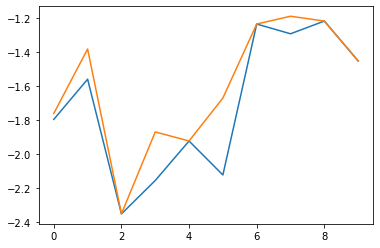

In [429]:
plt.plot(pre_error)
plt.plot(past_error)

In [430]:
latent_Z = Z_new[0]
for i in range(1, test_samples):
    latent_Z = np.vstack((latent_Z,Z_new[i]))
latent_Z = latent_Z.reshape(test_samples,timesteps,1)

##### Mapping test data back to latent space (LAB)

In [203]:
# Generate random samples
Z = np.random.normal(loc=0, scale=1, size=[test_samples, timesteps, features])

In [117]:
# set sample
s = 2

In [118]:
def reconstruction_error_sample(Z, *args):
    Z_reshape = np.reshape(Z,(1, timesteps, features))
    G = gen.predict(Z_reshape)
    correlation = np.corrcoef(X_te[s], G[0], rowvar=False)
    similarity_sample = np.diag(correlation[features:]) # crosscorrelation
    error_sample = 1 - similarity_sample
    return error_sample

In [120]:
Z[s]

array([[ 1.45276163],
       [-0.03823972],
       [-0.63261617],
       [-1.85748504],
       [ 0.79237693],
       [-0.27174539],
       [-0.63750517],
       [-0.1899426 ],
       [ 0.72921116],
       [-0.99105994],
       [ 0.32814313],
       [ 0.90987998],
       [ 0.6190701 ],
       [ 1.126425  ],
       [ 0.17357617],
       [ 0.80604166],
       [ 4.257085  ],
       [ 4.72692763],
       [ 1.75809248],
       [ 0.71049351],
       [-0.37858686],
       [-1.29420501],
       [ 1.32602389],
       [-0.06756519],
       [-0.64443231],
       [ 1.32566115],
       [-0.09603442],
       [ 0.56566921],
       [ 0.55495892],
       [-0.74636601]])

In [121]:
X_te[s].shape

(30, 1)

In [132]:
from scipy.optimize import least_squares
Z_k = least_squares(reconstruction_error_sample_2, Z[s,:,0], args=(X_te[s]))

In [123]:
Z_k.x - Z[s,:,0]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.30382354,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.97058527,  0.        ,  0.        , -7.82294822,  0.        ,
        0.        , -0.21895412,  0.        ,  0.        ,  0.        ])

In [124]:
G = gen.predict(Z)

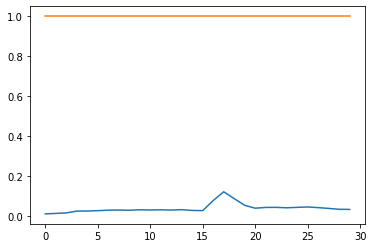

In [125]:
plt.plot(G[s])
plt.plot(X_te[s])

In [126]:
reconstruction_error_sample_2(Z[s])

-0.9607835596427321

In [127]:
Z[s] = Z_k.x.reshape(timesteps,1)

In [128]:
G = gen.predict(Z)

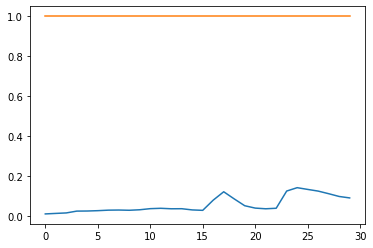

In [129]:
plt.plot(G[s])
plt.plot(X_te[s])

In [130]:
reconstruction_error_sample_2(Z[s])

-0.9419419440751274

##### Calculate scores

In [431]:
# Calculate reconstruction residuals
generated_X = gen.predict(latent_Z)
reconstruct_res = 0
for i in range(features):
    reconstruct_res += abs(X_te - generated_X)

In [432]:
# Calculate discrimination residuals
disc_res = abs(0.9 - disc(X_te))

In [228]:
#discrimination = []
#for i in period:
#    temp = np.sin(2 * np.pi * x / i)
#    X_te[0] = temp.reshape(timesteps,1)
#    discrimination.append(np.abs(0.9 - disc(X_te)[0]))
#plt.plot(period, discrimination)

In [436]:
# Calculate combined
w = 0
L = np.zeros((test_samples, timesteps, features))
for i in range(timesteps):
    L[:,i] = w * reconstruct_res[:,i] + (1-w) * disc_res

In [437]:
# Calculate DR-score
score_all = np.zeros(test_length)
count = np.zeros(test_length)
for j in range(test_samples):
    for s in range(timesteps):
        score_all[j+s] += L[j, s]
        count[j+s] += 1
dr_score = np.divide(score_all, count)

/Users/EmilAndersson/opt/anaconda3/envs/anomaly_detection/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


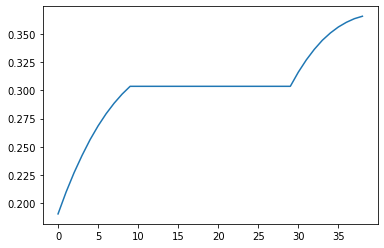

In [438]:
plt.plot(dr_score);

### LSTM

## Evaluation

In [ ]:
def eval(pred_anomaly_bool, anomaly_bool):
    confusion = confusion_matrix(pred_anomaly_bool, anomaly_bool)
    precision = precision_score(pred_anomaly_bool, anomaly_bool)        
    recall = recall_score(pred_anomaly_bool, anomaly_bool)
    return confusion, precision, recall

### Isolation Forest

In [ ]:
if_pred_anomaly_bool = anomaly_df['Predicted anomaly'] == -1
if_anomaly_bool = (anomaly_df['Point anomaly'] != 0)

[c, p, e] = eval(if_pred_anomaly_bool, if_anomaly_bool)